In [0]:
!pip install --upgrade texttable git+https://github.com/lorenzobasile/DeepRobust.git

  Cloning https://github.com/lorenzobasile/DeepRobust.git to /tmp/pip-req-build-cyjqlwaq
  Running command git clone -q https://github.com/lorenzobasile/DeepRobust.git /tmp/pip-req-build-cyjqlwaq
Requirement already up-to-date: texttable in /usr/local/lib/python3.6/dist-packages (1.6.2)
  Created wheel for deeprobust: filename=deeprobust-0-cp36-none-any.whl size=142419 sha256=55534cee12b4591b8ab04c3c631367de511d8fdf81ff56e16cc32856bbddde27
  Stored in directory: /tmp/pip-ephem-wheel-cache-go6hnq5z/wheels/73/c5/ae/8043f3f08a70c4c2a4584449a4f97f415682a4f0371f8f3890
Successfully built deeprobust
  Found existing installation: deeprobust 0
    Uninstalling deeprobust-0:
      Successfully uninstalled deeprobust-0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms,datasets
from IPython import display
import os
from torch.utils.data import DataLoader
import deeprobust.image.netmodels.train_model as trainmodel
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.attack.onepixel import Onepixel
from deeprobust.image.config import attack_params
import deeprobust.image.netmodels.CNN as MODEL
from deeprobust.image.defense.pgdtraining import PGDtraining
from deeprobust.image.config import defense_params
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive

torch.manual_seed(2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))
    
def get_params_num(net):
    return sum(map(torch.numel, net.parameters()))

    
def get_accuracy(dataloader, model, device='cpu'):
    tot = len(dataloader.dataset)
    with torch.no_grad():
        n_right = 0
        for data in dataloader:
            batch = data[0].to(device)
            labels = data[1].to(device)
            
            outputs = model(batch)
            out_labels = torch.argmax(outputs, dim=1)
            n_right += torch.sum(labels == out_labels)
    return float(n_right) / tot

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive
Device: cuda:0


In [0]:
# import BTSD and transform
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((64,64)),                            
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3])
    ]),
}


data_dir = './BelgiumTSC/'
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}
dataloaders = {'Training': DataLoader(datasets['Training'], batch_size=32, shuffle=True),'Testing': DataLoader(datasets['Testing'], batch_size=8, shuffle=True)}
dataset_sizes = {x: len(datasets[x]) for x in ['Training', 'Testing']}
class_names = datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda


In [0]:
print(dataloaders['Training'].dataset)
print()
print(dataloaders['Testing'].dataset)
net=torchvision.models.googlenet(pretrained=True, progress=True)
net.fc=nn.Linear(net.fc.in_features,62)
#print(net)

Dataset ImageFolder
    Number of datapoints: 4575
    Root location: ./BelgiumTSC/Training
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3])
           )

Dataset ImageFolder
    Number of datapoints: 2520
    Root location: ./BelgiumTSC/Testing
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3])
           )


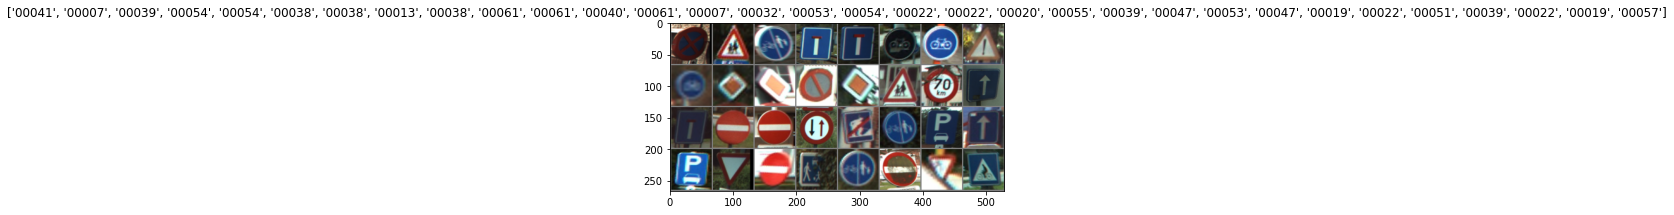

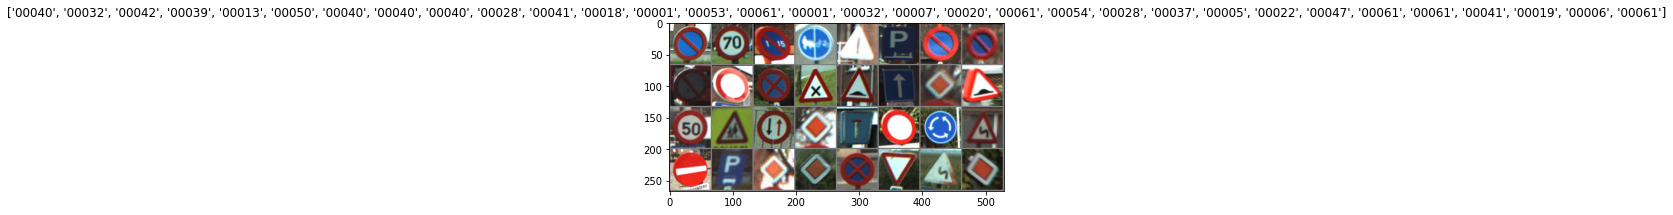

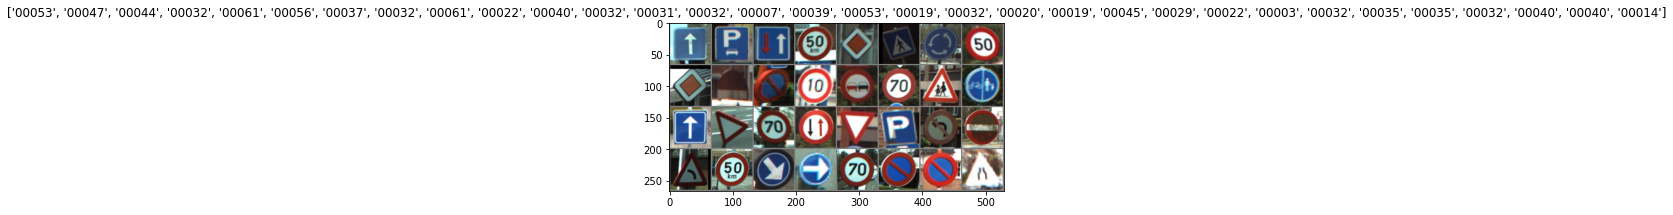

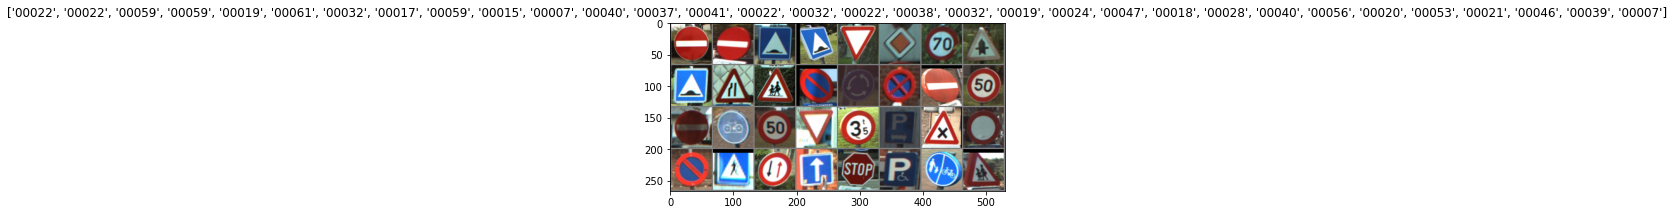

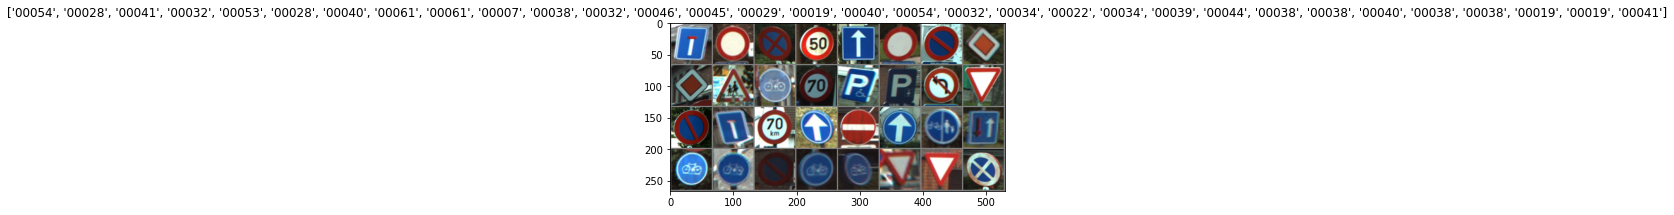

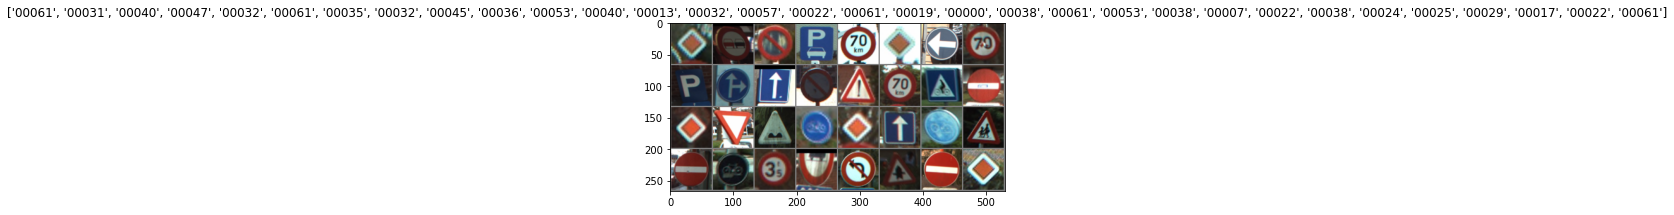

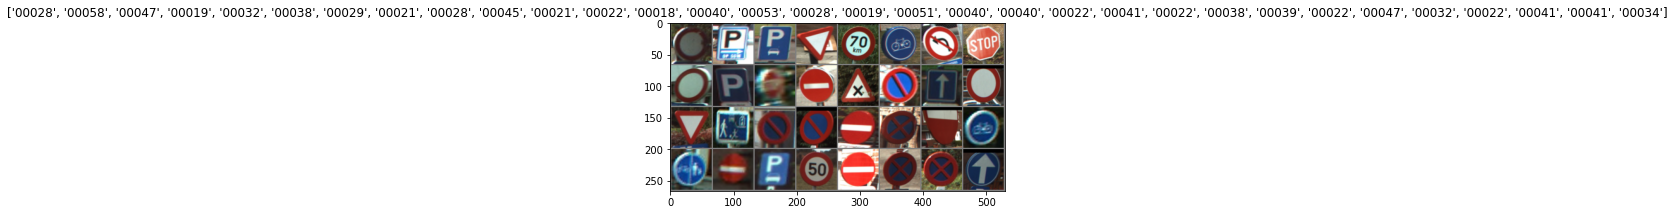

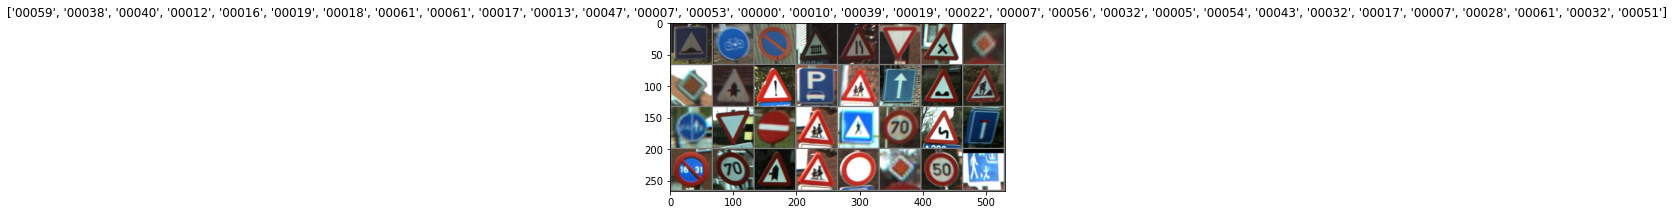

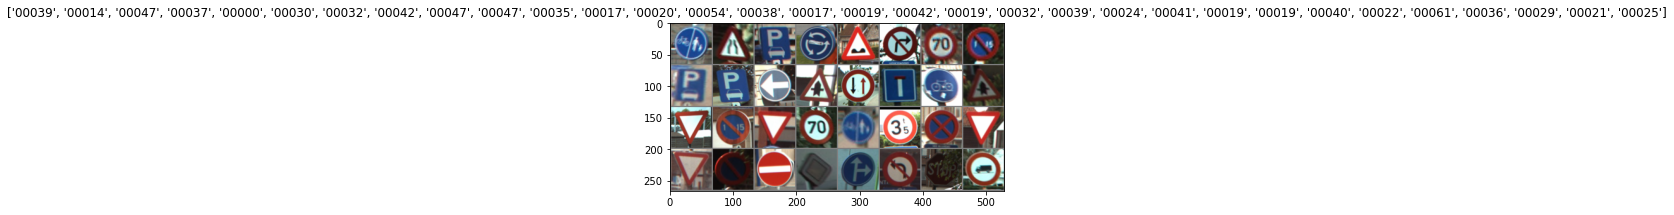

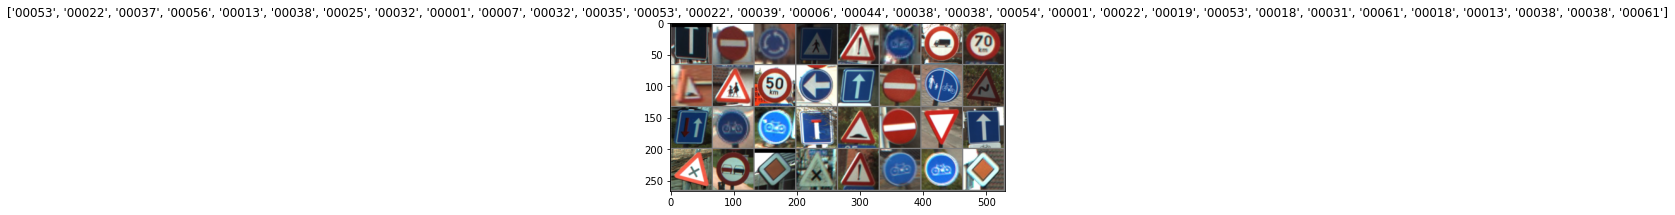

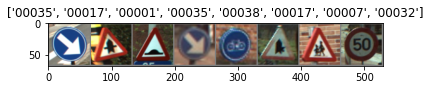

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.3, 0.3, 0.3])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
i=0
while i<10:
    i+=1
    inputs, classes = next(iter(dataloaders['Training']))


    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[class_names[x] for x in classes])
inputs, classes = next(iter(dataloaders['Testing']))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [0]:
net.to(device)
lr = 0.001
epochs = 20

n_batches = len(dataloaders['Training'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

net.train() 
for e in range(epochs):
    for i, data in enumerate(dataloaders['Training']):
        batch = data[0].to(device)
        labels = data[1].to(device)      
        outputs = net(batch)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print("[EPOCH]: {}, [BATCH]: {}/{}, [LOSS]: {}".format(e, i, n_batches, loss.item()))
            display.clear_output(wait=True)
    scheduler.step()

[EPOCH]: 19, [BATCH]: 100/143, [LOSS]: 0.00033138692378997803


In [0]:
#CLEAN ACCURACIES ON TRAIN AND TEST
acc_train = get_accuracy(dataloaders['Training'], net, device=device)
print("Train accuracy: {}".format(acc_train))
net.eval()
acc_test = get_accuracy(dataloaders['Testing'], net, device=device)
print("\nTest accuracy: {}".format(acc_test))

Train accuracy: 0.9997814207650273

Test accuracy: 0.9837301587301587


2520
0.9837301587301587
torch.Size([8, 3, 64, 64])


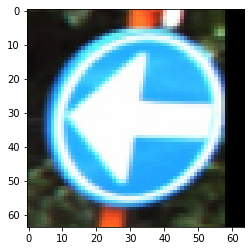

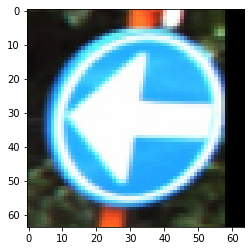

In [0]:

from deeprobust.image.attack.pgd import PGD
tot=len(dataloaders['Testing'].dataset)
print(tot)
n_right=0
for x,y in iter(dataloaders['Testing']):
    x = x.to('cuda').float()
    y = y.to('cuda').float()
    adversary = PGD(net, 'cuda')
    Adv_img = adversary.generate(x, y, epsilon=0.0)
    out_labels = torch.argmax(net(Adv_img), dim=1)
    #normal_pred = torch.argmax(net(x), dim=1)
    n_right += torch.sum(y == out_labels)
print(float(n_right) / tot)
#x, y = next(iter(dataloaders['Testing']))
#x = x.to('cuda').float()
#y = y.to('cuda').float()

#adversary = FGSM(net, 'cuda')
#Adv_img = adversary.generate(x, y)
print(Adv_img.size())
 
imshow(x[0].cpu().detach())
imshow(Adv_img[0].cpu().detach())

In [0]:
imshow(x[8].cpu().detach())
imshow(Adv_img[8].cpu().detach())

IndexError: ignored

In [0]:
from torchvision import transforms,datasets
from deeprobust.image.config import defense_params
from deeprobust.image.defense.pgdtraining import PGDtraining
net.to(device)
#from deeprobust.image.defense.pgdtraining import 
data_dir = './BelgiumTSC/'
datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}
dataloaders = {'Training': DataLoader(datasets['Training'], batch_size=32, shuffle=True),'Testing': DataLoader(datasets['Testing'], batch_size=64, shuffle=True)}
dataset_sizes = {x: len(datasets[x]) for x in ['Training', 'Testing']}
class_names = datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
net.to(device)
net.train() 

defense = PGDtraining(net, device)
defense.generate(train_loader=dataloaders['Training'], test_loader=dataloaders['Testing'], epsilon=0.1, epoch= 20,
                 lr = 0.001, save_model = False)

Device: cuda:0
1
Train Epoch: 1 [0/4575 (0%)]	Loss: 1.986861	Accuracy:0.00%
Train Epoch: 1 [320/4575 (7%)]	Loss: -0.048450	Accuracy:3.44%
Train Epoch: 1 [640/4575 (14%)]	Loss: -0.565081	Accuracy:16.88%
Train Epoch: 1 [960/4575 (21%)]	Loss: -0.625753	Accuracy:21.56%
Train Epoch: 1 [1280/4575 (28%)]	Loss: -2.086202	Accuracy:31.25%
Train Epoch: 1 [1600/4575 (35%)]	Loss: -2.460907	Accuracy:38.12%
Train Epoch: 1 [1920/4575 (42%)]	Loss: -2.857281	Accuracy:41.56%
Train Epoch: 1 [2240/4575 (49%)]	Loss: -3.160719	Accuracy:47.81%
Train Epoch: 1 [2560/4575 (56%)]	Loss: -3.271265	Accuracy:45.62%
Train Epoch: 1 [2880/4575 (63%)]	Loss: -4.012032	Accuracy:50.00%
Train Epoch: 1 [3200/4575 (70%)]	Loss: -4.309667	Accuracy:53.75%
Train Epoch: 1 [3520/4575 (77%)]	Loss: -4.627329	Accuracy:56.56%
Train Epoch: 1 [3840/4575 (84%)]	Loss: -4.805847	Accuracy:60.62%
Train Epoch: 1 [4160/4575 (91%)]	Loss: -5.088263	Accuracy:63.12%
Train Epoch: 1 [4480/4575 (98%)]	Loss: -5.218308	Accuracy:60.62%

Test set: Clean lo

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

torch.Size([1, 3, 64, 64])


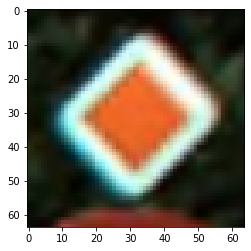

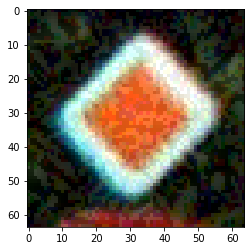

In [0]:
data_dir = './BelgiumTSC/'

datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}
dataloaders = {'Training': DataLoader(datasets['Training'], batch_size=1, shuffle=True),'Testing': DataLoader(datasets['Testing'], batch_size=1, shuffle=True)}
dataset_sizes = {x: len(datasets[x]) for x in ['Training', 'Testing']}
class_names = datasets['Training'].classes
from deeprobust.image.attack.fgsm import FGSM
x, y = next(iter(dataloaders['Testing']))
x = x.to('cuda').float()
y = y.to('cuda').float()

adversary = FGSM(net, 'cuda')
Adv_img = adversary.generate(x, y)
print(Adv_img.size())
 
imshow(x[0].cpu().detach())
imshow(Adv_img[0].cpu().detach())

In [0]:
adversary.generate?

In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [0]:
def test( model, device, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    acc_init=0
    adv_examples = []
    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        #print(target.item())

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = torch.argmax(output, dim=1) # get the index of the max log-probability
        #print(init_pred.item())
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue
             

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 10):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 10:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader)*acc_test)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader)*acc_test, final_acc))
    #print(acc_init/float(len(test_loader)))
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [0]:
accuracies = []
examples = []
epsilons=[0,0.05,0.1,0.2]
# Run test for each epsilon
for eps in epsilons:
    print(eps)
    acc, ex = test(net, device, dataloaders['Testing'], eps)
    accuracies.append(acc)
    examples.append(ex)

0
Epsilon: 0	Test Accuracy = 2381 / 2381.0 = 1.0
0.05
Epsilon: 0.05	Test Accuracy = 1882 / 2381.0 = 0.7904241915161697
0.1
Epsilon: 0.1	Test Accuracy = 1407 / 2381.0 = 0.5909281814363713
0.2
Epsilon: 0.2	Test Accuracy = 864 / 2381.0 = 0.3628727425451491


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

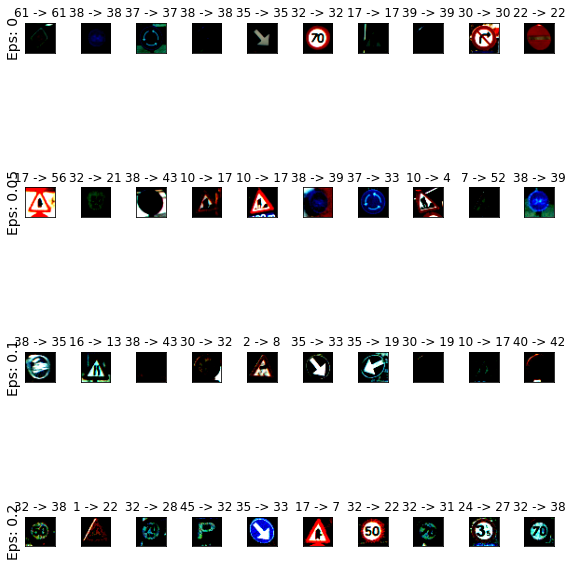

In [0]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        ex = np.transpose(ex, (1, 2, 0))
        plt.imshow(ex)
plt.tight_layout()
plt.show()

In [0]:
%cd ..

/content/gdrive


In [0]:
%ls

'My Drive'/


In [0]:
%cd My\ Drive
%ls

/content/gdrive/My Drive
 05_sorting.gdoc
 09_projection_and_minimal_fe.ipynb
 albanese/
 altro/
 BelgiumTSC/
 blackfriday7.ipynb
 BlackFriday.csv
'Colab Notebooks'/
 data/
 deep/
 DeepRobust/
 dtmc_notebook.ipynb
 dtmc_part2.ipynb
 finetuned_500.h5
 finetuned_501.h5
 finetuned_502.h5
 finetuned_503.h5
 finetuned_504.h5
 finetuned_lr0.h5
 finetuned_lr1.h5
 finetuned_lr20.h5
 finetuned_lr21.h5
 finetuned_lr22.h5
 finetuned_lr23.h5
 finetuned_lr24.h5
 finetuned_lr2.h5
 finetuned_lr3.h5
 finetuned_lr4.h5
 homework_02.ipynb
 landuse/
 landusefinetuned0.h5
 landusefinetuned1.h5
 landusefinetuned2.h5
 Leaf
 leaf_0.h5
 leaf_1.h5
 lenet_mnist_model.pth
'mcmc (1).ipynb'
 MCMC_beta.ipynb
 MCMC.ipynb
 medvet/
 MNIST/
'models for DeepRobust'/
 montecarlo.m
 predictions0.txt
 predictions1.txt
 predictions2.txt
 predictions3.txt
 predictions4.txt
'Presentazione di PowerPoint  -  Presentazione.pptx 12_07_2019 11_45_22.mp4'
 probabilistic_programming_exercises.ipynb
 prog/
'sampling_exercises (1).ipyn